In [139]:
import pandas as pd
import numpy as np

from news_vec.corpus import Corpus

from tqdm import tqdm
from boltons.iterutils import windowed
from collections import Counter
from itertools import combinations
from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
corpus = Corpus('../data/clf-links.json/', '../data/clf-headlines.json/')

2018-12-26 02:11:37,618 | INFO : Reading links.
1225511it [00:03, 351585.48it/s]
2018-12-26 02:11:42,995 | INFO : Reading headlines.
1127502it [00:21, 53170.27it/s]


In [12]:
min_dts_count = corpus.links.groupby(['domain', 'ts_bucket']).size().min()

In [30]:
def a_vs_b(d1, d2, ts_bucket, n=10):
    
    rows = (corpus.links
         [(corpus.links.domain.isin([d1, d2])) & (corpus.links.ts_bucket==ts_bucket)]
         .groupby(['domain', 'ts_bucket'])
         .apply(lambda x: x.sample(min_dts_count)))
    
    ds = corpus.make_dataset(rows)
    df = ds.to_df()
    
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )
    
    clf = LinearSVC()
    
    X = tv.fit_transform(df.tokens)
    
    return cross_val_score(clf, X, df.domain, cv=n, n_jobs=-1)

In [47]:
domains = corpus.unique_articles.domain.unique()

In [48]:
pairs = list(combinations(domains, 2))

In [ ]:
rows = []
for a, b in tqdm(pairs):
    for i in tqdm(range(10)):
        scores = a_vs_b(a, b, i, 100)
        for s in scores:
            rows.append((a, b, i, s))

In [121]:
sdf = pd.DataFrame(rows, columns=('d1', 'd2', 'b', 'acc'))

In [122]:
sdf

,d1,d2,b,acc
0,apnews.com,bloomberg.com,0,0.777778
1,apnews.com,bloomberg.com,0,0.851852
2,apnews.com,bloomberg.com,0,0.833333
3,apnews.com,bloomberg.com,0,0.851852
4,apnews.com,bloomberg.com,0,0.814815
5,apnews.com,bloomberg.com,0,0.851852
6,apnews.com,bloomberg.com,0,0.833333
7,apnews.com,bloomberg.com,0,0.907407
8,apnews.com,bloomberg.com,0,0.740741
9,apnews.com,bloomberg.com,0,0.851852


In [124]:
sdf.to_json('ab-ts.json', orient='records', lines=True)

apnews.com bloomberg.com
LinregressResult(slope=-0.0005905637572304239, intercept=0.8206639471639472, rvalue=-0.032443196687371154, pvalue=0.30539593544247806, stderr=0.0005759028127749441)


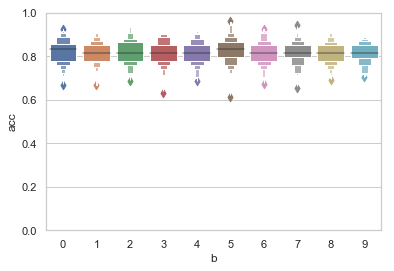

apnews.com buzzfeed.com
LinregressResult(slope=0.0038618233618233693, intercept=0.9006951566951565, rvalue=0.2811520348484511, pvalue=1.2677266913179701e-19, stderr=0.00041725808730815495)


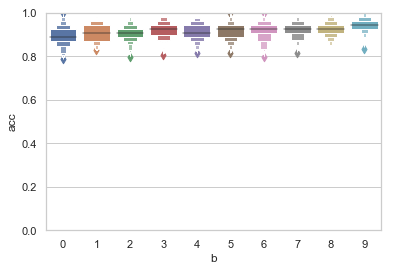

apnews.com dailycaller.com
LinregressResult(slope=0.0011779331779331775, intercept=0.8024243719243719, rvalue=0.06275403770590587, pvalue=0.047263583593970496, stderr=0.0005930029861383696)


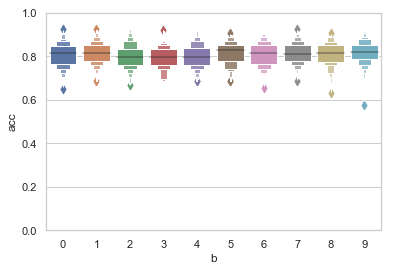

apnews.com dailykos.com
LinregressResult(slope=-0.004055900889234224, intercept=0.8978975653975653, rvalue=-0.26143268518985757, pvalue=4.335138024359224e-17, stderr=0.00047401191855240193)


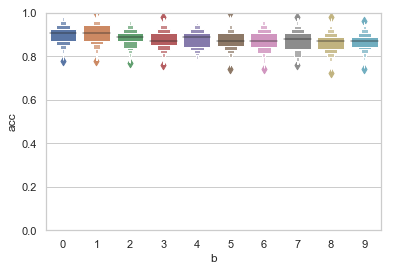

apnews.com foxnews.com
LinregressResult(slope=0.005789475956142617, intercept=0.66896373996374, rvalue=0.25543211024436757, pvalue=2.32834166344035e-16, stderr=0.0006936609723463151)


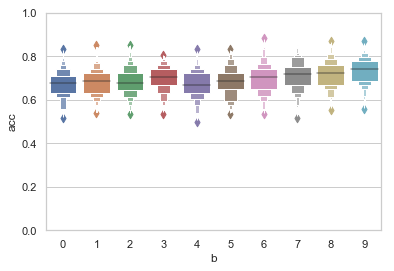

apnews.com huffingtonpost.com
LinregressResult(slope=-0.003567426400759735, intercept=0.8289245014245015, rvalue=-0.1886232327266898, pvalue=1.8396259310102736e-09, stderr=0.0005879331646956037)


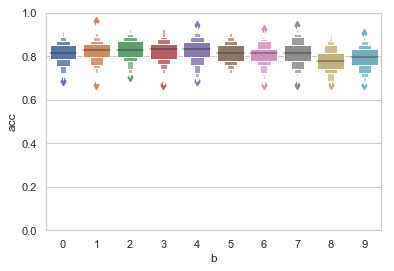

apnews.com npr.org
LinregressResult(slope=-0.00037835621168954344, intercept=0.7614084434084434, rvalue=-0.018966346739453622, pvalue=0.54912467994148, stderr=0.0006313552337995413)


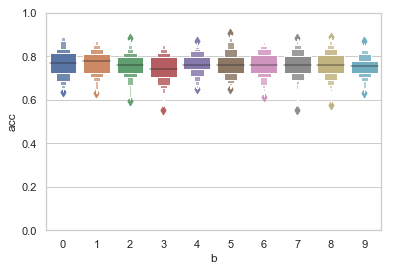

apnews.com nytimes.com
LinregressResult(slope=0.0030212811879478537, intercept=0.7630317275317277, rvalue=0.1511025544360074, pvalue=1.5875216354265582e-06, stderr=0.0006256604343402888)


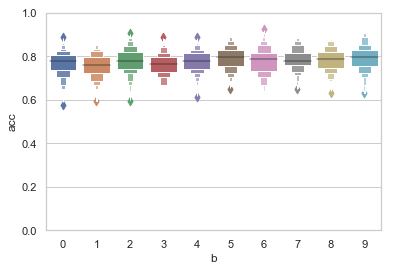

apnews.com thehill.com
LinregressResult(slope=-0.004585038418371757, intercept=0.8167017612017612, rvalue=-0.2391815768160903, pvalue=1.7791892107730186e-14, stderr=0.000589193528369158)


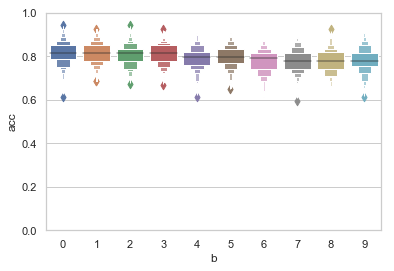

apnews.com washingtonpost.com
LinregressResult(slope=0.0021440904774238105, intercept=0.7842817922817923, rvalue=0.1127441300716316, pvalue=0.0003539699806448926, stderr=0.0005981443351214911)


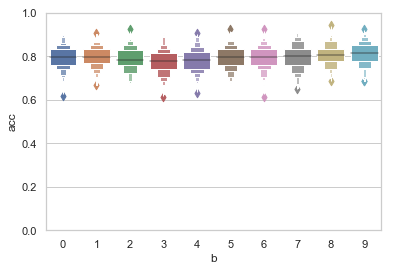

In [141]:
for d1, d2 in pairs[:10]:
    pdf = sdf[(sdf.d1==d1)&(sdf.d2==d2)]
    print(d1, d2)
    print(stats.linregress(pdf.b, pdf.acc))
    plt.ylim(0, 1)
    sns.boxenplot(x='b', y='acc', data=pdf)
    plt.show()